In [1]:
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
# load targets
filepath = '/home/peter/Data/DeepBind/rnac/'
df = pd.read_csv(os.path.join(filepath,'targets.tsv'), sep='\t')
targets = df.as_matrix()
targets = np.array(targets).astype(float)
num_data, num_labels = targets.shape

In [59]:
# replace nan values with mean
mu = np.mean(targets, axis=0)
for i in range(num_labels):
    targets[np.isnan(targets[:,i]),i] = mu[i]
    
# transform data to have less variance
#pos_targets = targets - np.outer(np.ones(num_data), np.min(targets,axis=0)) + 1
#log_targets = np.log(pos_targets)
#log_targets -= np.outer(np.ones(num_data), np.mean(log_targets,axis=0))

# clip targets
MAX = 15
MIN = -5
log_targets = targets
log_targets[log_targets > MAX] = MAX
log_targets[log_targets < MIN] = MIN

10.0

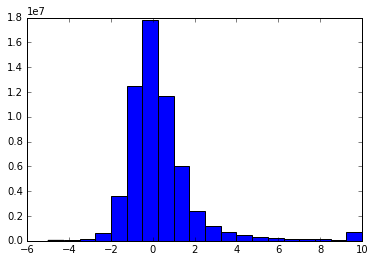

In [60]:
x = np.reshape(log_targets,(-1,))
plt.figure()
plt.hist(x,bins=20);
np.max(log_targets)

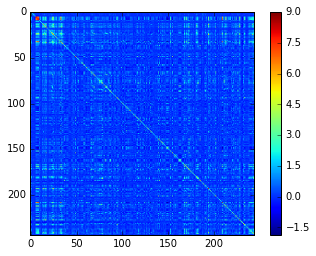

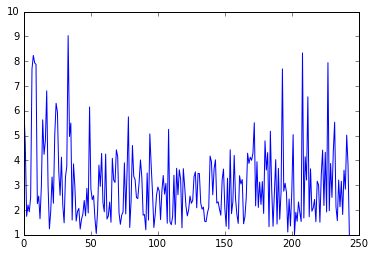

In [61]:
# calculate covariance matrix
C = np.cov(log_targets.T)

# image of covariance matrix (large variances are skewing distribution)
plt.figure()
plt.imshow(C)
plt.colorbar()

# plot of the variance
plt.figure()
plt.plot(np.diag(C))

In [62]:
# transform data to decorrelate and make standard normal variables
L = np.linalg.cholesky(C)
Linv = np.linalg.inv(L)
decorr_targets = np.dot(Linv,log_targets.T).T
decorr_targets.shape

(241357, 244)

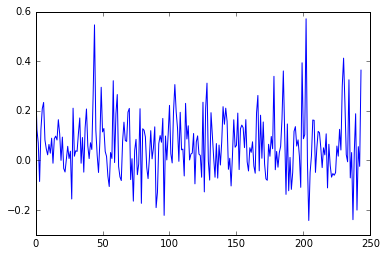

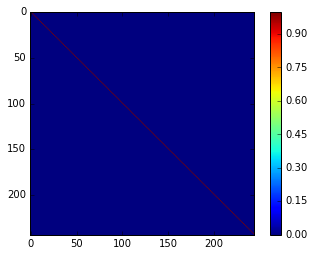

In [63]:
plt.figure()
plt.plot(np.mean(decorr_targets, axis=0))

C2 = np.cov(decorr_targets.T)
plt.figure()
plt.imshow(C2)
plt.colorbar()

In [64]:
# load sequence data
df = pd.read_csv(os.path.join(filepath,'sequences.tsv'), sep='\t')
data = df.as_matrix()
foldid = data[:,0]
name = data[:,1]
sequence = data[:,2]
max_length = df.seq.str.len().max()

In [68]:
# loop through each label and generate a sequence 
def convert_one_hot(sequence, max_length):
    nucleotide = 'ACGU'
    one_hot_seq = []
    for seq in sequence:
        seq_length = len(seq)        
        one_hot = np.zeros((4,seq_length))
        one_hot[0,np.where(seq == 'A')[0]] = 1
        one_hot[1,np.where(seq == 'C')[0]] = 1
        one_hot[2,np.where(seq == 'G')[0]] = 1
        one_hot[3,np.where(seq == 'U')[0]] = 1
        offset1 = ((max_length - seq_length)/2).astype(int)
        offset2 = max_length - seq_length - offset1

        if offset1:
            one_hot = np.hstack([np.ones((4,offset1))/4, one_hot])
        if offset2:
            one_hot = np.hstack([one_hot, np.ones((4,offset2))/4])

        one_hot_seq.append(one_hot)

    # convert to numpy array
    one_hot_seq = np.array(one_hot_seq)
    return one_hot_seq


one_hot_seq = convert_one_hot(sequence, max_length)

In [69]:
def split_dataset(seq, labels, split_size):
    # generate a shuffled subset of data for train, validation, and test
    num_seq = len(seq)
    num_labels = len(np.unique(labels))
    
    cum_index = np.cumsum(np.multiply([0, split_size[0], split_size[1], split_size[2]],num_seq)).astype(int) 
    shuffle = np.random.permutation(num_seq)
    
    train_index = shuffle[range(cum_index[0], cum_index[1])]
    valid_index = shuffle[range(cum_index[1], cum_index[2])]
    test_index = shuffle[range(cum_index[2], cum_index[3])]

    # create subsets of data based on indices 
    train = (seq[train_index], labels[train_index])
    valid = (seq[valid_index], labels[valid_index])
    test = (seq[test_index], labels[test_index])
    
    return train, valid, test
    
# split dataset into training cross validation and testing
train_size = 0.7
valid_size = 0.15
test_size = 0.15
split_size = [train_size, valid_size, test_size]
train, valid, test = split_dataset(one_hot_seq, log_targets, split_size)

In [70]:
import h5py

def save_dataset(savepath, train, valid, test):
    f = h5py.File(savepath, "w")
    dset = f.create_dataset("trainx", data=train[0])
    dset = f.create_dataset("trainy", data=train[1])
    dset = f.create_dataset("validx", data=valid[0])
    dset = f.create_dataset("validy", data=valid[1])
    dset = f.create_dataset("testx", data=test[0])
    dset = f.create_dataset("testy", data=test[1])
    f.close()

savename = "rnac.hdf5"
save_dataset(os.path.join(filepath,savename), train, valid, test)

In [71]:
os.path.join(filepath,savename)

'/home/peter/Data/DeepBind/rnac/rnac.hdf5'